In [1]:
import pandas as pd
import sys
sys.path.append('../src') 
from data_loader import ChestXray8Dataset
from models.cnn import ResNet50
import time
import torch.optim as optim
import torch.nn as nn

import os
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Progession bar

# Configuration settings
data_dir = Path.cwd().parent / 'data'
images_dir = data_dir / 'images'
metadata_dir = data_dir /'metadata'/ 'Data_Entry_2017_v2020.csv'
train_list_path = data_dir /'metadata'/ 'train_val_list.txt'
test_list_path = data_dir / 'metadata' /'test_list.txt'
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Redimensionar a 224x224
    transforms.ToTensor(),                     # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
train_val_dataset = ChestXray8Dataset(
    img_dir=images_dir, 
    metadata_file=metadata_dir, 
    split_file=train_list_path,
    mode='train',  # Training mode
    transform=transform
)
test_dataset = ChestXray8Dataset(
    img_dir=images_dir, 
    metadata_file=metadata_dir, 
    split_file=test_list_path,
    mode='test',  # Training mode
    transform=transform
)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
import torch.nn as nn
import torchvision.models as models

# Cargar el modelo ResNet50 preentrenado
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modificar la última capa para que coincida con el número de clases
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 14)  # 14 clases para las patologías

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np

# Definir el optimizador y la función de pérdida
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Función de validación
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())
    epoch_loss = running_loss / len(val_loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    return epoch_loss, all_labels, all_preds

# Entrenamiento y validación del modelo
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_labels, val_preds = validate_model(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Guardar las métricas de entrenamiento y validación
metrics_df = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'train_loss': train_losses,
    'val_loss': val_losses
})
metrics_df.to_csv('training_validation_metrics.csv', index=False)

Epoch 1/10, Train Loss: 0.1558, Val Loss: 0.1546
Epoch 2/10, Train Loss: 0.1499, Val Loss: 0.1494
Epoch 3/10, Train Loss: 0.1469, Val Loss: 0.1475
Epoch 4/10, Train Loss: 0.1443, Val Loss: 0.1444
Epoch 5/10, Train Loss: 0.1422, Val Loss: 0.1437
Epoch 6/10, Train Loss: 0.1404, Val Loss: 0.1448
Epoch 7/10, Train Loss: 0.1388, Val Loss: 0.1419
Epoch 8/10, Train Loss: 0.1371, Val Loss: 0.1415
Epoch 9/10, Train Loss: 0.1354, Val Loss: 0.1410
Epoch 10/10, Train Loss: 0.1333, Val Loss: 0.1406


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluar el modelo en el conjunto de prueba
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_labels.append(labels.cpu().numpy())
        test_preds.append(outputs.cpu().numpy())

test_labels = np.concatenate(test_labels)
test_preds = np.concatenate(test_preds)
test_preds = (test_preds > 0.5).astype(int)

# Guardar las etiquetas y predicciones en archivos de texto
np.savetxt('test_labels.txt', test_labels)
np.savetxt('test_preds.txt', test_preds)

# Generar el informe de clasificación y la matriz de confusión
classification_report_str = classification_report(test_labels, test_preds, target_names=list(train_dataset.dataset.label_mapping.keys()), zero_division=0)
confusion_matrix_str = confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))

# Guardar el informe de clasificación en un archivo
with open('classification_report.txt', 'w') as f:
    f.write(classification_report_str)

# Guardar la matriz de confusión en un archivo
with open('confusion_matrix.txt', 'w') as f:
    f.write(np.array2string(confusion_matrix_str))

print("Training and evaluation complete. Metrics saved to 'training_validation_metrics.csv', 'classification_report.txt', and 'confusion_matrix.txt'.")

Training and evaluation complete. Metrics saved to 'training_validation_metrics.csv', 'classification_report.txt', and 'confusion_matrix.txt'.


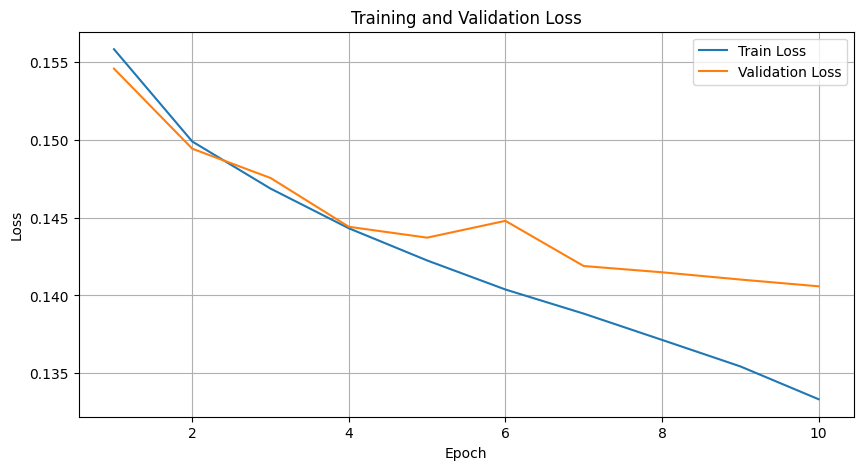

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar las métricas de entrenamiento y validación desde el archivo CSV
metrics_df = pd.read_csv('training_validation_metrics.csv')

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

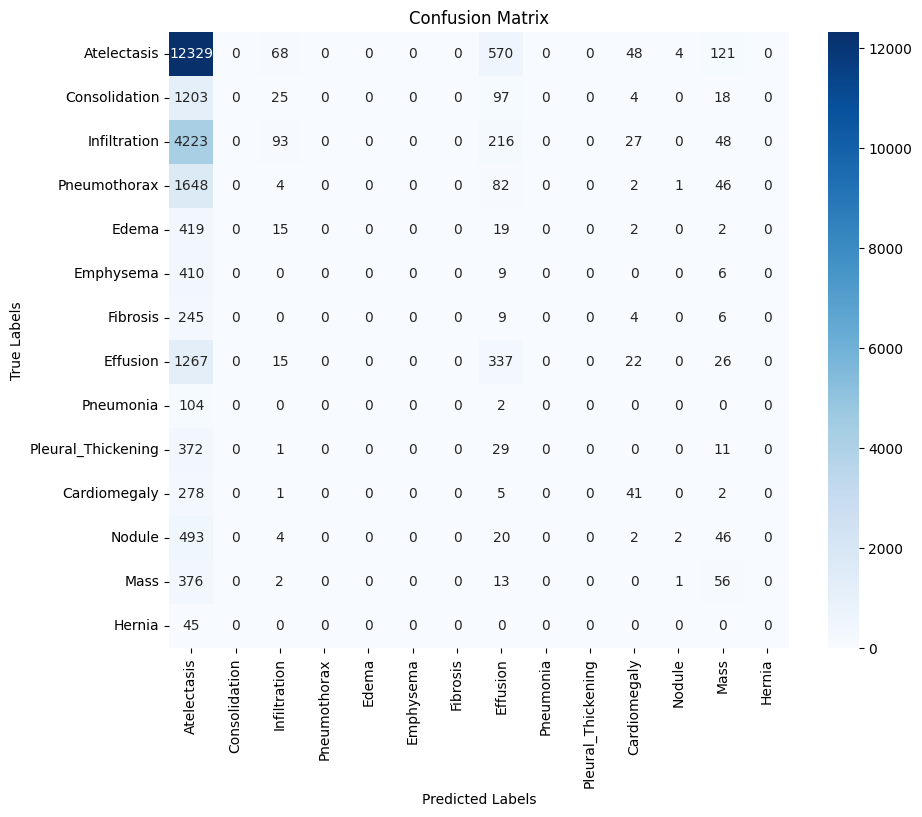

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Cargar las etiquetas y predicciones del conjunto de prueba desde los archivos TXT
test_labels = np.loadtxt('test_labels.txt')
test_preds = np.loadtxt('test_preds.txt')
# Graficar la matriz de confusión
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), test_preds.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(train_dataset.dataset.label_mapping.keys()), yticklabels=list(train_dataset.dataset.label_mapping.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


In [12]:
from sklearn.metrics import classification_report

# Generar el informe de clasificación
classification_report_str = classification_report(test_labels, test_preds, target_names=list(train_dataset.dataset.label_mapping.keys()))
print("Classification Report:\n", classification_report_str)

# Guardar el informe de clasificación en un archivo
with open('classification_report.txt', 'w') as f:
    f.write(classification_report_str)

Classification Report:
                     precision    recall  f1-score   support

       Atelectasis       0.55      0.02      0.05      3279
     Consolidation       0.00      0.00      0.00      1815
      Infiltration       0.46      0.02      0.03      6112
      Pneumothorax       0.00      0.00      0.00      2665
             Edema       0.50      0.00      0.00       925
         Emphysema       0.00      0.00      0.00      1093
          Fibrosis       0.00      0.00      0.00       435
          Effusion       0.60      0.19      0.29      4658
         Pneumonia       0.00      0.00      0.00       555
Pleural_Thickening       0.00      0.00      0.00      1143
      Cardiomegaly       0.56      0.09      0.15      1069
            Nodule       0.25      0.00      0.00      1623
              Mass       0.46      0.11      0.18      1748
            Hernia       0.00      0.00      0.00        86

         micro avg       0.56      0.05      0.09     27206
         macro

c:\Users\MEDHYCON\anaconda3\envs\tfm_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MEDHYCON\anaconda3\envs\tfm_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MEDHYCON\anaconda3\envs\tfm_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
